# 02 - Data from the Web

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


## 1. World University Rankings by TopUniversities

---
<div class="alert alert-block alert-info">
<b>Task</b>: 
<ol>
    <li>Obtain the 200 top-ranking universities in www.topuniversities.com (<a href="https://www.topuniversities.com/university-rankings/world-university-rankings/2018">ranking 2018</a>). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the <a href="https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl">details page</a>.    
Store the resulting dataset in a pandas DataFrame and answer the following questions:
    <li>
Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?</li>
    <li>
Answer the previous question aggregating the data by (c) country and (d) region.</li>

Plot your data using bar charts and describe briefly what you observed.
</div>

---

We will focus on data scraping from the [TopUniversities 2018 rankings](https://www.topuniversities.com/university-rankings/world-university-rankings/2018), as well as asnwering the assignment questions by performing simple data analysis. The structure of this chapter follows the assignment outline:

1. Data scraping
2. Ranking: faculty members, students and internationalization
3. Ranking: regional and national results


### Libraries utilized

We will use the BeautifulSoup along with Pandas and standard Python utilities for performing the scraping and data analysis.

In [1]:
# importing the utils for Web scraping
import requests
from bs4 import BeautifulSoup

# importing python and data utils
import pandas as pd
import numpy as np
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Swiss army knife for data scraping

[Postman](https://www.getpostman.com/) is utilized outside Python to get more sense about the Web jungle we are trying to harvest our data from. We have used both Interceptor and the application itself to make sense of incoming traffic. 

We have also relied on traffic observations in Chrome Development Tools (*which can be accessed in Chrome browsers on Windows platform by pressing F12*).

### 1.1 Data scraping

The first step in our data scraping process was to get acquainted with the website itself. We have turned on the Interceptor for the traffic and the application itself, then loaded the website and observed the requests. 

#### Making our life easier: Postman filters

It is useful to filter out results of requests sent to the Website of interest. In modern websites it is common to have many 3rd party APIs which would make it somewhat more difficult to find the requests of interest. Additionally, trafic from other tabs in browser (if open) will appear, so it is additionally useful to display only what is the focus of our search. Such benefits are visible in the practical example bellow:

<table width="70%">
  <tr>
    <th style="text-align:center">Requests without any filters</th>
    <th style="text-align:center">After filtering results from *www.topuniversities.com* only</th> 
  </tr>
  <tr>
    <td>![](images/postman0.png)</td>
    <td style="vertical-align:top">![](images/postman1.png)</td> 
  </tr>
</table>

From the vast list of various requests, we have localized what seems to be important for the given task, and the requests for resources for the TopUniversity rankings. By analyzing the requests, we can see one **GET** request which obtains a textual file:

[https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508597583828](https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508597583828)

By analyzing the file, it turns out to be a very useful JSON! All the data needed for scraping at this level is present here, most notably the ranking and the URL towards more information. It correlates to the same information we can directly see from the Chrome Developer Tools:

![](images/chrome0.png)

#####  Design choice
As in the image above can be seen, the HTML data is well organized in the tables, with appropriate classes which designate the content of the cell. One approach would be to use `BeautifulSoup` and parse the HTML of the page. Since we have the data in more concise format (JSON) we decided to process the textual representation. Since only the representation and intermediate steps differ, and results are the same, this is a choice we have made. 

Nevertheless, further steps will have to rely on parsing the HTML and DOM of the subsequent university links with further details (since no equivalent JSON is obtained), so both approaches are showcased.


#### Implementing the scraping procedure

We will extract the before found JSON file and use it as a baseline for scraping this Website. We send a GET request and process the file as JSON.

In [2]:
## TU = TopUniversities
TU_path = 'https://www.topuniversities.com'
base_json_path = '/sites/default/files/qs-rankings-data/357051.txt?_=1508597583828'

req = requests.get(TU_path+base_json_path)

TU_json = req.json()

We convert the JSON file to Pandas `DataFrame` to enable easier exploration and utilization of the file. We are interested in the **data** section of our JSON file, and we take the first 200 top ranking universities in the list. 

Notably, some universities share the same ranking (tie). Per assignment at this point we will take 200 best ranking universities for our analysis, and not the universities until the rank 200.

In [3]:
TU_df = pd.DataFrame.from_dict(TU_json['data']).head(200)

We can observe that we did not need any additional parsing which would add both to code complexity, potential computational overhead in bigger datasets, as well as algorithmic complexity if the website HTML code is not tidy (which is not the case here). The `DataFrame` carries all the information we need for now, of which the region, country, rank, title and url play the significant role in the task.

In [4]:
TU_df.head(2)

,cc,core_id,country,guide,logo,nid,rank_display,region,score,stars,title,url
0,US,410,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294850,1,North America,100,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,US,573,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",297282,2,North America,98.7,5,Stanford University,/universities/stanford-university


#### 1.1.1 Extracting the information for each University

Some information such as University name or rank is available immediately, while for detailed information we need to follow the subsequent link provided in the **url** field. Unfortunately, as previously mentioned, we don't have information packed in JSON format this time. We use HTML parsing provided by `BeautifulSoup` to obtain all the missing data. We are in luck since the HTML is well organized, with appropriate classes assigned to `div`s containing needed pieces of information.

We iterate through the previously obtained `DataFrame` and scrape and collect the necessary data, and append it to the existing `DataFrame`.

#### Note on undefined values

At least one of the universities has missing data and we need to handle such cases. If the number of such cases is small enough, we could impute the values manually, by consulting the appropriate sources, thus keeping the consistency of the rankings. If we don't have all the data for our specific analysis, we would have to discard such Universities or come up with a methodology for mining up missing data on larger scale.

We choose to be consistent and we will print out the universities which have some missing values and will try to fill in the missing values. In such manner we differentiate **raw values** such as the number of students and **derived values** such as different scores provided. 

   #####      Raw values
We will try to impute raw values from various sources since we will use such data in further data analysis. Such data might be available directly from the websites of Universities.

   #####      Derived values
We will not attempt to impute derived values, such as different scores calculated by the selected ranking Website. Methodologies are often incomplete and all the collected raw values unavailable. Any methodology for imputing such values would be most probably very erroneous. Since such data is not extensively used for analysis, it is acceptable to leave some of such values undefined.

In [5]:
# A helper function to get an number (integer) from the div text
def div2num(div):
    return int(div.find('div', class_='number').text.split()[0].replace(',',''))

# A helper function to get the percentage from the span text
def perc2num(div):
    return int(div.find('span', class_='perc').text.replace('%',''))

#### Additional information from the links

Landing page has provided a general overview of the most important pieces of information, such as names and ranks of universities. We further scrape the data provided in the links for each university. The base `DataFrame` already exists, now we enrich it with more detailed data, and we iterate and fill the available information.

In [6]:
# iterating through the existing base dataframe
for ind, row in TU_df.iterrows():
    # getting the detailed page of the given university
    # relative link to the page is given in the url field of the dataframe
    uni_details = requests.get(TU_path+row['url'])
    
    # get the HTML of the detailed university page and add it to the soup
    soup = BeautifulSoup(uni_details.text, 'html.parser')
    
    # get the name of the university from the DF
    uni_name = row['title']
    
    # get the number of faculty members from the detailed page and append to DF
    faculty_num = soup.find('div', class_='total faculty')
    try:
        # we parse the div text and append it to the DataFrame
        TU_df.loc[ind, 'Total faculty members'] = div2num(faculty_num)
    except:
        # print out the message in order to try to impute the data
        print('Undefined total faculty members for: '+uni_name)
    
    # similar procedure for other required data points
    # Total number of students
    students_num = soup.find('div', class_='total student')
    try:
        TU_df.loc[ind, 'Total students'] = div2num(students_num)
    except:
        print('Undefined total students for: '+uni_name)
    
    # Percentage of postgraduate students
    try:
        total_postgrad_percentage = students_num.find('div', class_='post')
        TU_df.loc[ind, 'Total postgrad percentage'] = perc2num(total_undergrad_percentage)
    except:
        print('Undefined Total postgrad percentage for: '+uni_name)
    
    # Percentage of undergraduate students
    try:
        total_undergrad_percentage = students_num.find('div', class_='grad')
        TU_df.loc[ind, 'Total undergrad percentage'] = perc2num(total_undergrad_percentage)
    except:
        print('Undefined Total undergrad percentage for: '+uni_name)
    
    # Number of international faculty members
    intl_faculty_num = soup.find('div', class_='inter faculty')
    try:
        TU_df.loc[ind, 'International faculty members'] = div2num(intl_faculty_num)
    except:
        print('Undefined international faculty members for: '+uni_name)
    
    # Total number of international students
    intl_students_num = soup.find('div', class_='total inter')
    try:
        TU_df.loc[ind, 'International students'] = div2num(intl_students_num)
    except:
        print('Undefined international students for: '+uni_name)
    
    # International postgraduate students percentage
    try:
        intl_postgrad_percentage = intl_students_num.find('div', class_='post')
        TU_df.loc[ind, 'International postgrad percentage'] = perc2num(intl_postgrad_percentage)
    except:
        print('Undefined International postgrad percentage for: '+uni_name)
    
    # International undergraduate students percentage
    try:
        intl_undergrad_percentage = intl_students_num.find('div', class_='grad')
        TU_df.loc[ind, 'International undergrad percentage'] = perc2num(intl_undergrad_percentage)
    except:
        print('Undefined International undergrad percentage for: '+uni_name)
        
    # Find all the scores, iterate through them
    try:
        scores_list = soup.find('ul', class_='score').find_all('li')
        for score in scores_list:
            try:
                criteria = score.find('div', class_='criteria').text.strip()
                value = float(score.find('div', class_='text').text)
                TU_df.loc[ind, criteria] = value
            except:
                print('Undefined '+criteria+' for: '+uni_name)
    except:
        print('No scores available at all for: '+uni_name)


Undefined Total postgrad percentage for: Massachusetts Institute of Technology (MIT)
Undefined total faculty members for: New York University (NYU)
Undefined total students for: New York University (NYU)
Undefined Total postgrad percentage for: New York University (NYU)
Undefined Total undergrad percentage for: New York University (NYU)
Undefined international faculty members for: New York University (NYU)
Undefined international students for: New York University (NYU)
Undefined International postgrad percentage for: New York University (NYU)
Undefined International undergrad percentage for: New York University (NYU)
No scores available at all for: New York University (NYU)
Undefined International undergrad percentage for: Pohang University of Science And Technology (POSTECH)
Undefined International undergrad percentage for: Indian Institute of Technology Delhi (IITD)
Undefined international faculty members for: Indian Institute of Science (IISc) Bangalore
Undefined International under

##### Scores

Scores are variables in range from 0.0 to 100.0, floating point value. They are derived from the parameters collected, surveys conducted and described in more detail in the provided [methodology](https://www.topuniversities.com/qs-world-university-rankings/methodology). As prior described they would not be imputed if missing since the error induced in this case, as well as the value of such variable would be low.

#### Imputing undefined values

We can see that the New York University (NYU) has information that is completely missing, while Indian Institute of Science (IISc) Bangalore has one missing raw value. Considering the scope of missing values, they will be manually set using the following sources:

- NYU: https://www.nyu.edu/about/news-publications/nyu-at-a-glance.html, https://www.nyu.edu/admissions/undergraduate-admissions/nyu-facts.html
- IISc: http://www.iisc.ac.in/iisc-in-numbers/#ffs-tabbed-12

This is potentially troubling, since there is no information about the actual data collection for the ranking, methodology or actual date which is available for a confident selection of the figures missing. Frequently, the websites also omit the precise dates. Comparing the potential noise which would be added to the fact that we would discard 2 top 200 universities, the decision is to take the data and impute it, while being aware that it might induce some error in methodology. It is a tradeoff between statistical error in imputed data and the error which would occur in the further aggregate analysis.

Therefore the NYU data is following:
- total faculty members: 7861 (Fall 2015)
- total students: 58419 (Fall 2015)
- international faculty members: 619 (September 2017)
- international students: 26% == 15189 (Fall 2015)

Unfortunately, the data of international faculty members is not available in public records online for IISc, therefore it will be designated as 0. The unavailability might rise from the fact that the figure is [rather low](https://scroll.in/article/811696/there-are-no-indian-universities-in-the-worlds-top-250-list-heres-how-javadekar-can-change-that), so it would not be positive for faculty to publicize such information. 

Here we try to follow the rule not to completely penalize omission of data if possible, as described in [THE methodology](https://www.timeshighereducation.com/world-university-rankings/methodology-world-university-rankings-2016-2017):
> *On the rare occasions when a particular data point is not provided we enter a low estimate between the average value of the indicators and the lowest value reported: the 25th percentile of the other indicators. By doing this, we avoid penalising an institution too harshly with a “zero” value for data that it overlooks or does not provide, but we do not reward it for withholding them.*



**If time permitted a good practice would be to contact the institution directly for the actual quote in both cases.**

In [7]:
TU_df.loc[TU_df.title=='New York University (NYU)','Total faculty members'] = 7861
TU_df.loc[TU_df.title=='New York University (NYU)','Total students'] = 58419
TU_df.loc[TU_df.title=='New York University (NYU)','International faculty members'] = 619
TU_df.loc[TU_df.title=='New York University (NYU)','International students'] = 15189


TU_df = TU_df.fillna(0)

#### Pruning the data in DataFrame

We have several pieces of information that are redundant at this point, so we will remove such columns from the DataFrame for a better overview. We can see bellow that *cc*, *rank_display*, *stars*, *core_id*, *guide*, *logo*, *nid* and *url* are present, but redundant in the following analysis.

In [8]:
TU_df.head(1)

,cc,core_id,country,guide,logo,nid,rank_display,region,score,stars,...,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage
0,US,410,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294850,1,North America,100,6,...,83.0,17.0,100.0,100.0,99.9,100.0,100.0,100.0,96.1,0.0


In [9]:
TU_df.drop(['cc', 'stars', 'core_id', 'guide', 'logo', 'nid', 'url'], axis=1, inplace=True)
TU_df.head(1)

,country,rank_display,region,score,title,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage
0,United States,1,North America,100,Massachusetts Institute of Technology (MIT),2982.0,11067.0,40.0,1679.0,3717.0,83.0,17.0,100.0,100.0,99.9,100.0,100.0,100.0,96.1,0.0


#### We have our DataFrame ready for further analysis!
---

### 1.2 Ranking: faculty members, students and internationalization

<div class="alert alert-block alert-info">
In this section we answer the question: <br><b>Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?</b>
</div>

For easier analysis for (a) and (b) we will add the ratios to the existing DataFrame:

In [10]:
# ratio between faculty members and students
TU_df['Ratio faculty/students'] = TU_df['Total faculty members']/TU_df['Total students']

# ratio of international students
TU_df['Ratio intl/total students'] = TU_df['International students']/TU_df['Total students']

In [11]:
TU_df.head(1)

,country,rank_display,region,score,title,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,...,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage,Ratio faculty/students,Ratio intl/total students
0,United States,1,North America,100,Massachusetts Institute of Technology (MIT),2982.0,11067.0,40.0,1679.0,3717.0,...,100.0,100.0,99.9,100.0,100.0,100.0,96.1,0.0,0.26945,0.335863


We have prepared the data for our analysis! The results are obtained by sorting the `DataFrame` by appropriate criterion.

### Best university: (a) ratio between faculty members and students

In [12]:
TU_fac_stud_df = TU_df.sort_values('Ratio faculty/students', ascending=False)

#### Top 5 by ratio of faculty members and students:

In [13]:
TU_fac_stud_df.head(5)

,country,rank_display,region,score,title,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,...,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage,Ratio faculty/students,Ratio intl/total students
3,United States,4,North America,97.7,California Institute of Technology (Caltech),953.0,2255.0,44.0,350.0,647.0,...,97.7,99.5,100.0,85.4,100.0,93.4,89.2,31.0,0.422616,0.286918
15,United States,16,North America,90.4,Yale University,4940.0,12402.0,44.0,1708.0,2469.0,...,90.4,100.0,63.2,99.8,100.0,90.7,61.7,82.0,0.398323,0.199081
5,United Kingdom,6,Europe,95.3,University of Oxford,6750.0,19720.0,56.0,2964.0,7353.0,...,95.3,100.0,76.3,100.0,100.0,98.6,98.5,63.0,0.342292,0.372870
4,United Kingdom,5,Europe,95.6,University of Cambridge,5490.0,18770.0,63.0,2278.0,6699.0,...,95.6,100.0,78.3,100.0,100.0,97.4,97.7,44.0,0.292488,0.356899
16,United States,17,North America,89.8,Johns Hopkins University,4462.0,16146.0,37.0,1061.0,4105.0,...,89.8,94.3,83.9,66.4,100.0,87.9,81.3,44.0,0.276353,0.254243


### Best university: (b) ratio of international students

In [14]:
TU_intl_df = TU_df.sort_values('Ratio intl/total students', ascending=False)

#### Top 5 by ratio of international students

In [15]:
TU_intl_df.head(5)

,country,rank_display,region,score,title,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,...,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage,Ratio faculty/students,Ratio intl/total students
34,United Kingdom,35,Europe,81.8,London School of Economics and Political Scien...,1088.0,9760.0,47.0,687.0,6748.0,...,81.8,90.3,71.7,100.0,55.9,100.0,100.0,73.0,0.111475,0.691393
11,Switzerland,12,Europe,91.2,Ecole Polytechnique Fédérale de Lausanne (EPFL),1695.0,10343.0,52.0,1300.0,5896.0,...,91.2,83.0,99.2,95.5,92.0,100.0,100.0,82.0,0.163879,0.570047
7,United Kingdom,8,Europe,93.7,Imperial College London,3930.0,16090.0,57.0,2071.0,8746.0,...,93.7,99.4,68.7,100.0,100.0,100.0,100.0,52.0,0.244251,0.543567
198,Netherlands,200,Europe,47.9,Maastricht University,1277.0,16385.0,63.0,502.0,8234.0,...,47.9,30.8,73.3,39.0,35.4,95.9,100.0,83.0,0.077937,0.502533
47,United States,=47,North America,78.6,Carnegie Mellon University,1342.0,13356.0,49.0,425.0,6385.0,...,78.6,85.0,95.6,85.1,43.2,62.3,100.0,78.0,0.100479,0.478062


------
### 1.3 Ranking: regional and national results

In this section we use the results obtained in **1.2** and aggregate them, separately, by country and region, thus providing answer to the question 2:

<div class="alert alert-block alert-info">
<i>Answer the previous question aggregating the data by (c) country and (d) region.</i>
</div>


The `DataFrame` contains all the datapoints we need for answering the questions, the only procedure we need to undertake is aggregation of data. We need to remove the calculated ratios per faculty since the summation would not result in proper result in this case (we would need to normalize the result otherwise). We can further remove the score and name of the university **manually**, since it does not play a role in the dataset, but since it is a variable on which we could not perform aggregation such variables would anyway be ignored by *Pandas*.

In [16]:
TU_aggregate_df = TU_df.copy()

columns_to_drop = ['Ratio faculty/students', 'Ratio intl/total students']

TU_aggregate_df.drop(columns_to_drop, axis=1, inplace=True)
TU_aggregate_df.head(1)

,country,rank_display,region,score,title,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage
0,United States,1,North America,100,Massachusetts Institute of Technology (MIT),2982.0,11067.0,40.0,1679.0,3717.0,83.0,17.0,100.0,100.0,99.9,100.0,100.0,100.0,96.1,0.0


---
#### Aggregating data by country (c)

We will group the data by the country and then sum the values of such aggregate to produce desired data.

In [17]:
# we can compose multiple functions to reduce code clutter with rule - column:['aggregation1', 'aggregation2'...]
rule = {'Total faculty members':['sum'], 'Total students':['sum'], 'Total undergrad percentage':['mean'], 
        'International faculty members':['sum'], 'International students':['sum'], 'International postgrad percentage':['mean'],
       'International undergrad percentage':['mean'], 'Overall Score':['mean'], 'Academic Reputation':['mean'],
       'Citations per Faculty':['mean'], 'Employer Reputation':['mean'], 'Faculty Student':['mean'], 'International Faculty':['mean'],
       'International Students':['mean'], 'Total postgrad percentage':['mean']}

TU_country_df = TU_aggregate_df.groupby(['country']).agg(rule)
TU_country_df.head(2)

,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage
,sum,sum,mean,sum,sum,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
country,,,,,,,,,,,,,,,
Argentina,16421.0,122301.0,93.000000,3165.0,27109.0,8.000000,92.000000,69.100000,94.500000,0.000000,95.500000,75.100000,50.300000,70.600000,52.000000
Australia,22034.0,301994.0,68.333333,11382.0,106359.0,49.555556,50.444444,72.544444,86.477778,72.011111,86.166667,15.644444,98.355556,93.955556,62.888889


As done previously, desired ratios are calculated and added to the `DataFrame`:

In [18]:
TU_country_df['Ratio faculty/students'] = TU_country_df['Total faculty members']/TU_country_df['Total students']
TU_country_df['Ratio intl/total students'] = TU_country_df['International students']/TU_country_df['Total students']

#### Top 5 countries with Universities with highest ratio of faculty to students

In [19]:
TU_country_df.sort_values('Ratio faculty/students', ascending=False).head(5)

,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage,Ratio faculty/students,Ratio intl/total students
,sum,sum,mean,sum,sum,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,,
country,,,,,,,,,,,,,,,,,
Russia,6709.0,30233.0,65.000000,373.0,5098.0,16.0,84.0,65.000000,82.000000,0.000000,79.60,99.7,0.0,48.70,88.000000,0.221910,0.168624
Denmark,11916.0,67223.0,53.333333,3904.0,9543.0,72.0,28.0,63.066667,61.066667,56.933333,49.10,78.0,85.4,46.70,63.666667,0.177261,0.141960
Saudi Arabia,1062.0,6040.0,86.000000,665.0,989.0,55.0,45.0,50.300000,35.700000,27.600000,40.50,94.9,100.0,46.60,52.000000,0.175828,0.163742
Singapore,9444.0,58466.0,82.000000,6079.0,16168.0,47.0,53.0,91.350000,96.950000,74.750000,98.25,91.2,100.0,87.15,56.000000,0.161530,0.276537
Malaysia,2755.0,17902.0,54.000000,655.0,3476.0,75.0,25.0,60.800000,65.700000,24.300000,57.50,87.8,65.4,59.70,64.000000,0.153893,0.194168


#### Top 5 countries with Universities with highest ratio of international students

In [20]:
TU_country_df.sort_values('Ratio intl/total students', ascending=False).head(5)

,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage,Ratio faculty/students,Ratio intl/total students
,sum,sum,mean,sum,sum,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,,
country,,,,,,,,,,,,,,,,,
Australia,22034.0,301994.0,68.333333,11382.0,106359.0,49.555556,50.444444,72.544444,86.477778,72.011111,86.166667,15.644444,98.355556,93.955556,62.888889,0.072962,0.352189
United Kingdom,79934.0,583621.0,71.750000,30216.0,199426.0,48.178571,51.821429,69.385714,70.507143,57.071429,77.546429,63.210714,91.825000,92.471429,62.928571,0.136962,0.341705
Hong Kong,10166.0,78838.0,75.600000,6296.0,24499.0,53.200000,46.800000,78.400000,85.480000,66.140000,73.360000,69.560000,99.960000,91.000000,54.400000,0.128948,0.310751
Austria,4117.0,63446.0,62.500000,1572.0,19667.0,42.500000,57.500000,51.400000,57.500000,41.850000,63.400000,0.000000,82.150000,92.500000,68.000000,0.064890,0.309980
Switzerland,15323.0,109112.0,50.857143,9208.0,32995.0,66.285714,33.714286,68.442857,61.357143,75.085714,62.785714,67.342857,99.942857,80.314286,53.714286,0.140434,0.302396


---
#### Aggregating data by region (d)

We perform the same procedure with grouping by the region instead of country.

In [21]:
# we can compose multiple functions to reduce code clutter with rule - column:['aggregation1', 'aggregation2'...]
rule = {'Total faculty members':['sum'], 'Total students':['sum'], 'Total undergrad percentage':['mean'], 
        'International faculty members':['sum'], 'International students':['sum'], 'International postgrad percentage':['mean'],
       'International undergrad percentage':['mean'], 'Overall Score':['mean'], 'Academic Reputation':['mean'],
       'Citations per Faculty':['mean'], 'Employer Reputation':['mean'], 'Faculty Student':['mean'], 'International Faculty':['mean'],
       'International Students':['mean'], 'Total postgrad percentage':['mean']}

TU_region_df = TU_aggregate_df.groupby(['region']).agg(rule)
TU_region_df.head(2)

,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage
,sum,sum,mean,sum,sum,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
region,,,,,,,,,,,,,,,
Africa,1733.0,19593.0,82.000000,379.0,3325.0,30.000000,70.000000,48.90,60.200000,35.900000,55.100000,32.900000,59.200000,49.200000,12.000000
Asia,106734.0,807003.0,60.578947,25462.0,110100.0,60.184211,39.815789,68.55,75.971053,61.655263,74.873684,69.321053,38.813158,27.392105,61.868421


We calculate the desired ratios by the region and then present the top 5 regions by each criterion.

In [22]:
TU_region_df['Ratio faculty/students'] = TU_region_df['Total faculty members']/TU_region_df['Total students']
TU_region_df['Ratio intl/total students'] = TU_region_df['International students']/TU_region_df['Total students']

#### Top 5 regions with Universities with the highest faculty to student ratio

In [23]:
TU_region_df.sort_values(['Ratio faculty/students'], ascending=False).head(5)

,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage,Ratio faculty/students,Ratio intl/total students
,sum,sum,mean,sum,sum,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,,
region,,,,,,,,,,,,,,,,,
Asia,106734.0,807003.0,60.578947,25462.0,110100.0,60.184211,39.815789,68.550000,75.971053,61.655263,74.873684,69.321053,38.813158,27.392105,61.868421,0.132260,0.136431
North America,189984.0,1604772.0,64.425926,44455.0,307305.0,54.425926,43.722222,70.153704,77.037037,72.733333,62.537037,58.829630,56.120370,56.168519,59.000000,0.118387,0.191494
Europe,218358.0,1957251.0,60.393258,67598.0,449364.0,59.617978,40.382022,62.704494,64.297753,57.067416,63.722472,55.447191,73.900000,65.389888,64.865169,0.111564,0.229589
Latin America,45382.0,435750.0,75.571429,5648.0,36871.0,62.142857,37.857143,55.500000,82.842857,7.957143,87.614286,37.828571,21.242857,13.400000,62.285714,0.104147,0.084615
Africa,1733.0,19593.0,82.000000,379.0,3325.0,30.000000,70.000000,48.900000,60.200000,35.900000,55.100000,32.900000,59.200000,49.200000,12.000000,0.088450,0.169703


#### Top 5 regions with Universities with the highest ratio of international students

In [24]:
TU_region_df.sort_values(['Ratio intl/total students'], ascending=False).head(5)

,Total faculty members,Total students,Total undergrad percentage,International faculty members,International students,International postgrad percentage,International undergrad percentage,Overall Score,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,Total postgrad percentage,Ratio faculty/students,Ratio intl/total students
,sum,sum,mean,sum,sum,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,,
region,,,,,,,,,,,,,,,,,
Oceania,25347.0,350167.0,71.000000,12786.0,118798.0,45.818182,54.181818,70.372727,84.945455,68.490909,82.063636,12.800000,97.336364,90.990909,64.636364,0.072385,0.339261
Europe,218358.0,1957251.0,60.393258,67598.0,449364.0,59.617978,40.382022,62.704494,64.297753,57.067416,63.722472,55.447191,73.900000,65.389888,64.865169,0.111564,0.229589
North America,189984.0,1604772.0,64.425926,44455.0,307305.0,54.425926,43.722222,70.153704,77.037037,72.733333,62.537037,58.829630,56.120370,56.168519,59.000000,0.118387,0.191494
Africa,1733.0,19593.0,82.000000,379.0,3325.0,30.000000,70.000000,48.900000,60.200000,35.900000,55.100000,32.900000,59.200000,49.200000,12.000000,0.088450,0.169703
Asia,106734.0,807003.0,60.578947,25462.0,110100.0,60.184211,39.815789,68.550000,75.971053,61.655263,74.873684,69.321053,38.813158,27.392105,61.868421,0.132260,0.136431


### Cleaning up the unnecessary data for further analysis

In [25]:
columns_to_delete = ['Total undergrad percentage', 'International postgrad percentage', 'International undergrad percentage', 'Total postgrad percentage',
                    'International Students', 'International Faculty', 'Faculty Student', 'Employer Reputation', 'Citations per Faculty', 'Academic Reputation',
                    'Overall Score']

TU_df.drop(columns_to_delete, axis=1, inplace=True)

## 2. World University Rankings by TimesHigherEducation

In this chapter, we will scrape the data from [TimesHigherEducation ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking), as well as answering the assignment questions by performing simple data analysis.


Pandas options setting for a better view of the data

In [26]:
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

### Analysis of the website to scrape

As in the case for task 1, we notice, using Interceptor Chrome app and Postman, that when accessing the main list url

http://timeshighereducation.com/world-university-rankings/2018/world-ranking 


another specific **GET** request is made to one of the server's REST API endpoints

https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json

which serves a file in JSON format that contains a data field with information about each university in the ranking.

#### Implementing the scrapping procedure

We begin by extracting the JSON file found previously with Interceptor and Postman and processing it as a JSON. In order to do so, we implement an utility function that sends a **GET** request to a server's API endpoint identified by the url.

The result is saved in a dictionary so that the http request is made only once per url.

In [27]:
json_data = {}
def get_json(url):
    if url not in json_data:
        r = requests.get(url)
        json_data[url] = r
    else:
        r = json_data[url]
        
    return r.json()

In [28]:
thedu_url = 'https://www.timeshighereducation.com'
thedu_json_url = '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

json_data_thedu = get_json(thedu_url + thedu_json_url)

#### Analysis of the json object format

In [29]:
# fields of the entire json object
display(json_data_thedu.keys())
# one entry in the data field
display(json_data_thedu['data'][0])

dict_keys(['data', 'subjects', 'locations', 'pillars'])

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

The retrieved json object has 4 fields: data, subjects, locations and pillars out of which we are interested only in data. Specifically in the first 200 entries in the corresponding array because, again, we are focusing on the 200 best ranking universities and not the universities until rank 200.

#### Structure of data

We observe that the data field contains the name, location which is basically the country, number of students, ratio of international students and ratio of student to staff which is enough to infer all the fields that are asked in the asignment, except the region and number of international faculty members. Therefore we are not required to aditionally scrape the detailed page of the univerities.

Additionally, we will keep in the DataFrame the scores_overall which will be later used for gathering insights about the merged data.

Given that the region of a country cannot variate, for this field we will use external information, for example the dataframe from the previous task, to infer the region of an university necessary for region-based statistics. 

The number of international faculty members is not provided by the TimesHigherEducation, but we do not need it in our further analysis related to this task.

Observing the data field is a list of records, it makes sense to load it in a DataFrame for easier manipulation.

In [30]:
data_thedu = pd.DataFrame(json_data_thedu['data'])

In [31]:
data_thedu.head()

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,scores_industry_income,scores_industry_income_rank,scores_international_outlook,scores_international_outlook_rank,scores_overall,scores_overall_rank,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,63.7,169,95.0,24,94.3,10,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,51.5,260,93.0,35,93.2,20,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,92.6,51,59.7,322,93.0,30,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,60.5,189,77.6,162,93.0,40,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,88.4,63,87.6,81,92.5,50,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


#### Restructuring the data

As argued above, we will keep in the DataFrame only the columns that are relevant to our analysis:
- name
- rank
- location
- stats_number_students
- stats_pc_intl_students
- stats_student_staff_ratio
- scores_overall

In [32]:
columns_to_drop = data_thedu.columns.difference(['name', 'rank','location', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio', 'scores_overall'])
data_thedu = data_thedu.drop(columns_to_drop, axis=1)[0:200]

In [33]:
data_thedu.stats_pc_intl_students.head()

0    38%
1    35%
2    27%
3    22%
4    34%
Name: stats_pc_intl_students, dtype: object

The column stats_pc_intl_students representing the percentage of international students does not have a format that allows us do the operations necessary to infer the number of international students. 

We will create a function that will parse the string values of this column and transform them into a value from [0,1]

In [34]:
def percentage_to_ratio(value):
    # we slice the value up until the last character
    # then parse it as an int and divide it by 100 to obtain a value between 0 and 1
    return int(value[:-1])/100

In [35]:
data_thedu['stats_pc_intl_students'] = data_thedu['stats_pc_intl_students'].apply(percentage_to_ratio)
data_thedu.rename(columns={'stats_pc_intl_students':'stats_intl_students_ratio'}, inplace=True)

In [36]:
data_thedu.head()

,location,name,rank,scores_overall,stats_number_students,stats_intl_students_ratio,stats_student_staff_ratio
0,United Kingdom,University of Oxford,1,94.3,"20,409",0.38,11.2
1,United Kingdom,University of Cambridge,2,93.2,"18,389",0.35,10.9
2,United States,California Institute of Technology,=3,93.0,"2,209",0.27,6.5
3,United States,Stanford University,=3,93.0,"15,845",0.22,7.5
4,United States,Massachusetts Institute of Technology,5,92.5,"11,177",0.34,8.7


### Inferring data

We can now proceed to infer the number of international students and the number of faculty members

The number of international students can be calculated as the product between the number of students and the international students ratio

The number of faculty members can be calculated as the number of students divided by the student per staff ratio

#### Data types

In [37]:
data_thedu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
location                     200 non-null object
name                         200 non-null object
rank                         200 non-null object
scores_overall               200 non-null object
stats_number_students        200 non-null object
stats_intl_students_ratio    200 non-null float64
stats_student_staff_ratio    200 non-null object
dtypes: float64(1), object(6)
memory usage: 11.0+ KB


As we can see, all the stats, except the transformed international students ratio, have the data type object.

For us to able to infer the new columns values, we will have to parse stats_number_students to int and stats_student_staff_ratio to float.

In [38]:
data_thedu['stats_number_students'] = data_thedu.stats_number_students.apply(lambda x: int(x.replace(',','')))
data_thedu['stats_student_staff_ratio'] = data_thedu.stats_student_staff_ratio.apply(lambda x: float(x))

We now compute the new columns as described above

In [39]:
data_thedu['number_international_students_inferred'] = data_thedu.stats_number_students * data_thedu.stats_intl_students_ratio
data_thedu['number_faculty_members_inferred'] = data_thedu.stats_number_students / data_thedu.stats_student_staff_ratio

Having only two decimals precision for the ratio, the resulting values for the inferred columns are not all integers but we choose to leave them as that in order to maintain the accuracy of our data.

One thing left to do is to transform the student per staff ratio into staff per student ratio as per assignment.

In [40]:
data_thedu['stats_student_staff_ratio'] = 1 / data_thedu.stats_student_staff_ratio
data_thedu.rename(columns={'stats_student_staff_ratio':'stats_staff_student_ratio'}, inplace=True)

In [41]:
data_thedu.head()

,location,name,rank,scores_overall,stats_number_students,stats_intl_students_ratio,stats_staff_student_ratio,number_international_students_inferred,number_faculty_members_inferred
0,United Kingdom,University of Oxford,1,94.3,20409,0.38,0.089286,7755.42,1822.232143
1,United Kingdom,University of Cambridge,2,93.2,18389,0.35,0.091743,6436.15,1687.064220
2,United States,California Institute of Technology,=3,93.0,2209,0.27,0.153846,596.43,339.846154
3,United States,Stanford University,=3,93.0,15845,0.22,0.133333,3485.90,2112.666667
4,United States,Massachusetts Institute of Technology,5,92.5,11177,0.34,0.114943,3800.18,1284.712644


We have prepared the data for our analysis! The results are obtained by sorting the `DataFrame` by appropriate criterion.

### Best university: (a) ratio between faculty members and students

In [42]:
thedu_fac_stud_df = data_thedu.sort_values('stats_staff_student_ratio', ascending=False)

#### Top 10 by ratio of faculty members and students

In [43]:
thedu_fac_stud_df.head(10)

,location,name,rank,scores_overall,stats_number_students,stats_intl_students_ratio,stats_staff_student_ratio,number_international_students_inferred,number_faculty_members_inferred
105,United States,Vanderbilt University,=105,60.0,12011,0.13,0.303030,1561.43,3639.696970
109,Denmark,University of Copenhagen,=109,59.4,30395,0.14,0.243902,4255.30,7413.414634
153,United States,University of Rochester,=153,55.6,9636,0.29,0.232558,2794.44,2240.930233
11,United States,Yale University,12,87.6,12155,0.21,0.232558,2552.55,2826.744186
12,United States,Johns Hopkins University,13,86.5,15498,0.24,0.232558,3719.52,3604.186047
97,United States,Emory University,98,60.7,12649,0.19,0.227273,2403.31,2874.772727
16,United States,Duke University,17,85.1,15256,0.22,0.222222,3356.32,3390.222222
114,France,École Polytechnique,115,59.1,2799,0.36,0.196078,1007.64,548.823529
183,Italy,Scuola Normale Superiore di Pisa,184,53.4,515,0.07,0.192308,36.05,99.038462
101,United States,University of Pittsburgh,=100,60.5,26367,0.10,0.169492,2636.70,4468.983051


Expected enough, even though the ratio of faculty members per students is important for a good university, it takes more than that for an university to reach top 10.

### Best university: (b) ratio of international students

In [44]:
thedu_intl = data_thedu.sort_values('stats_intl_students_ratio', ascending=False)

#### Top 5 by ratio of international students

In [45]:
thedu_intl.head(10)

,location,name,rank,scores_overall,stats_number_students,stats_intl_students_ratio,stats_staff_student_ratio,number_international_students_inferred,number_faculty_members_inferred
24,United Kingdom,London School of Economics and Political Science,=25,79.4,10065,0.71,0.081967,7146.15,825.000000
178,Luxembourg,University of Luxembourg,=179,53.8,4969,0.57,0.068493,2832.33,340.342466
37,Switzerland,École Polytechnique Fédérale de Lausanne,=38,75.3,9928,0.55,0.089286,5460.40,886.428571
7,United Kingdom,Imperial College London,8,89.2,15857,0.55,0.087719,8721.35,1390.964912
102,Netherlands,Maastricht University,103,60.4,16727,0.50,0.055556,8363.50,929.277778
15,United Kingdom,University College London,16,85.3,30304,0.49,0.095238,14848.96,2886.095238
143,United Kingdom,University of St Andrews,=143,56.6,9005,0.48,0.076923,4322.40,692.692308
23,United States,Carnegie Mellon University,24,81.9,12676,0.45,0.074074,5704.20,938.962963
120,United Kingdom,Queen Mary University of London,121,58.5,15405,0.45,0.075188,6932.25,1158.270677
39,Hong Kong,University of Hong Kong,40,75.1,18364,0.42,0.055556,7712.88,1020.222222


We can notice that, according to THE ranking and with the exception of the Imperial College London, the universities that attract the most international students with respect to the number of local students, are not the ones in top 10.

### National rankings

To compute the national rankings we have to aggregate the data by location(country) using the sum operation. 

Given that the sum of the ratio columns will not produce the desired result, we will drop them and compute the the national ratios from the number of students and the inffered columns of international students and faculty.

As the sum aggregation cannot be performed for name and rank which have dtype object, pandas will automatically  ignore them.

In [46]:
thedu_agg = data_thedu.copy()
thedu_agg.drop(['stats_intl_students_ratio', 'stats_staff_student_ratio'], axis=1, inplace=True)

In [47]:
thedu_country_agg = thedu_agg.groupby('location').sum()
thedu_country_agg.head()

,stats_number_students,number_international_students_inferred,number_faculty_members_inferred
location,,,
Australia,268630,83811.65,9940.035694
Austria,35375,9197.50,1700.721154
Belgium,130115,23768.44,3428.131589
Canada,249401,55905.59,13239.558680
China,253911,22882.57,21390.183014


We add the ratios, upon which we perform the rankings, as columns to the DataFrame

In [48]:
thedu_country_agg['Ratio faculty/student'] = thedu_country_agg.number_faculty_members_inferred/thedu_country_agg.stats_number_students
thedu_country_agg['Ratio intl/student'] = thedu_country_agg.number_international_students_inferred/thedu_country_agg.stats_number_students

#### Top 10 Countries with Universities with highest ratio of faculty to students

In [49]:
thedu_country_agg.sort_values('Ratio faculty/student', ascending=False).head(10)

,stats_number_students,number_international_students_inferred,number_faculty_members_inferred,Ratio faculty/student,Ratio intl/student
location,,,,,
Denmark,64110,9326.86,10598.011371,0.165310,0.145482
Russian Federation,29236,6431.92,4004.931507,0.136986,0.220000
Japan,48481,4398.48,6464.620003,0.133343,0.090726
Italy,1205,132.65,158.012821,0.131131,0.110083
Switzerland,107852,32745.97,10050.381246,0.093187,0.303619
United States,1705533,280364.88,152350.555408,0.089327,0.164385
Taiwan,31758,2540.64,2761.565217,0.086957,0.080000
South Africa,20775,3739.50,1775.641026,0.085470,0.180000
China,253911,22882.57,21390.183014,0.084243,0.090120


#### Top 5 Countries with Universities with highest ratio of international students

In [50]:
thedu_country_agg.sort_values('Ratio intl/student', ascending=False)

,stats_number_students,number_international_students_inferred,number_faculty_members_inferred,Ratio faculty/student,Ratio intl/student
location,,,,,
Luxembourg,4969,2832.33,340.342466,0.068493,0.570000
United Kingdom,596449,213059.74,44438.703287,0.074505,0.357214
Hong Kong,77663,25158.79,4141.416206,0.053325,0.323948
Australia,268630,83811.65,9940.035694,0.037003,0.311997
Singapore,56101,17085.29,3364.473475,0.059972,0.304545
Switzerland,107852,32745.97,10050.381246,0.093187,0.303619
New Zealand,30348,8800.92,1614.255319,0.053191,0.290000
Ireland,16157,4362.39,708.640351,0.043860,0.270000
Austria,35375,9197.50,1700.721154,0.048077,0.260000


One thing to notice here is that, skipping Luxembourg which has a small number of students in total, United Kindom seems the most international friendly country for students.

### Regional ranking

Not having region information in the TimesHigherEducation data, in order to do the regional ranking for task 2, we decide to infer the region from the TopUniversities data. We are doing this by creating a DataFrame, using the data from TopUniversities, that contains a mapping from country to region. The resulting df with contain unique rows with country and it's associated region.

We take this decision in order to be consistent with the statistics so that the resulting regional ranking for the two tasks to be comparable.

In [51]:
country_region_df = TU_aggregate_df[['country','region']].drop_duplicates().reset_index(drop=True)

We now make sure we have an entry in our mapping dataframe for each country in the TimesHigherEducation df. 

For this, we check whether there are countries that do not appear in the mapping df.

In [52]:
thedu_agg[~thedu_agg.location.isin(country_region_df['country'])]

,location,name,rank,scores_overall,stats_number_students,number_international_students_inferred,number_faculty_members_inferred
178,Luxembourg,University of Luxembourg,=179,53.8,4969,2832.33,340.342466
193,Russian Federation,Lomonosov Moscow State University,194,52.3,29236,6431.92,4004.931507


We can observe that Luxembourg and Russian Federation do not have a correspondent region. Doing a further analysis, we notice that in the mapping dataframe we do find Russian Federation, but under a different name: Russia

In [53]:
country_region_df.iloc[20]

country    Russia
region     Europe
Name: 20, dtype: object

In order to be consistent with the TopUniversities dataframe in order to facilitate the merging later on, we will change Russian Federation to Russia.

For Luxembourg, we will add a new entry in the mapping dataframe

In [54]:
thedu_agg[thedu_agg.location.isin(['Russian Federation'])]

,location,name,rank,scores_overall,stats_number_students,number_international_students_inferred,number_faculty_members_inferred
193,Russian Federation,Lomonosov Moscow State University,194,52.3,29236,6431.92,4004.931507


In [55]:
thedu_agg.at[193,'location'] = 'Russia'

#### Note

Observing the case with Russian Federation, to facilitate the merging later on, we will do this change for the original dataframe also

In [56]:
data_thedu.at[193, 'location'] = 'Russia'

In [57]:
luxembourg_entry = {'country':'Luxembourg', 'region':'Europe'}
country_region_df = country_region_df.append(luxembourg_entry, ignore_index=True)

In [58]:
country_region_df.tail(1)

,country,region
34,Luxembourg,Europe


Now that we have the country_region_df prepared, we can do the merge between the THE dataframe and the country to region mapping dataframe, with the purpose of adding a region column in the THE dataframe.

In [59]:
thedu_agg = pd.merge(thedu_agg, country_region_df, left_on='location', right_on='country')

In [60]:
thedu_agg.head(2)

,location,name,rank,scores_overall,stats_number_students,number_international_students_inferred,number_faculty_members_inferred,country,region
0,United Kingdom,University of Oxford,1,94.3,20409,7755.42,1822.232143,United Kingdom,Europe
1,United Kingdom,University of Cambridge,2,93.2,18389,6436.15,1687.064220,United Kingdom,Europe


In [61]:
thedu_agg.region.isnull().values.any()

False

We can now performe the same procedure for region as for the country.

In [62]:
thedu_agg_regions = thedu_agg.groupby('region').sum()

In [63]:
thedu_agg_regions['Ratio faculty/students'] = thedu_agg_regions['number_faculty_members_inferred']/thedu_agg_regions['stats_number_students']
thedu_agg_regions['Ratio intl/students'] = thedu_agg_regions['number_international_students_inferred']/thedu_agg_regions['stats_number_students']

In [64]:
thedu_agg_regions

,stats_number_students,number_international_students_inferred,number_faculty_members_inferred,Ratio faculty/students,Ratio intl/students
region,,,,,
Africa,20775,3739.50,1775.641026,0.085470,0.180000
Asia,530949,78837.67,42636.062289,0.080302,0.148484
Europe,2143623,481578.91,126864.001890,0.059182,0.224657
North America,1954934,336270.47,165590.114089,0.084704,0.172011
Oceania,298978,92612.57,11554.291013,0.038646,0.309764


Now that we have the ratios for each region, it's simply a matter of sorting by the appropriate criterion.

#### Top 5 Regions with Universities with highest faculty members to students ratio

In [65]:
thedu_agg_regions.sort_values('Ratio faculty/students', ascending=False).head()

,stats_number_students,number_international_students_inferred,number_faculty_members_inferred,Ratio faculty/students,Ratio intl/students
region,,,,,
Africa,20775,3739.50,1775.641026,0.085470,0.180000
North America,1954934,336270.47,165590.114089,0.084704,0.172011
Asia,530949,78837.67,42636.062289,0.080302,0.148484
Europe,2143623,481578.91,126864.001890,0.059182,0.224657
Oceania,298978,92612.57,11554.291013,0.038646,0.309764


#### Top 5 Regions with Universities with highest international students to students ratio

In [66]:
thedu_agg_regions.sort_values('Ratio intl/students', ascending=False).head()

,stats_number_students,number_international_students_inferred,number_faculty_members_inferred,Ratio faculty/students,Ratio intl/students
region,,,,,
Oceania,298978,92612.57,11554.291013,0.038646,0.309764
Europe,2143623,481578.91,126864.001890,0.059182,0.224657
Africa,20775,3739.50,1775.641026,0.085470,0.180000
North America,1954934,336270.47,165590.114089,0.084704,0.172011
Asia,530949,78837.67,42636.062289,0.080302,0.148484


One thing to be considered when looking at the previous ranking is that because we do not have data for the home country of international students, here the raking also takes into consideration the mobility of the students inside the region (students that go to an university in another country but in the same region)

### Visualization

We start our visual exploration of the data by trying to check for a correlation between the number of students a university has and its rank thinking that if an university as a higher rank, more students would try to study in that university. 

For this, we sample the first 10, middle 10 and last 10 universities according to their rank and use their number of students to create the barplots.

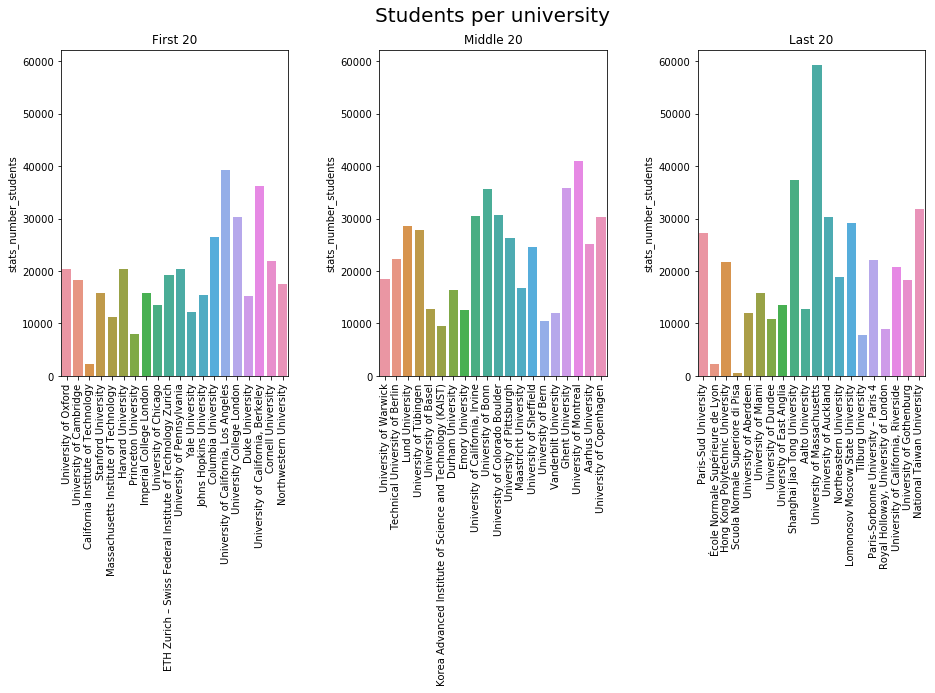

In [71]:
first_10 = data_thedu[:20]
middle_10 = data_thedu[90:110]
last_10 = data_thedu[-20:]

fig = plt.figure(figsize=(15,6))
fig.suptitle('Students per university', fontsize=20)

ax1 = plt.subplot(1, 3, 1)
sns.barplot(x='name', y='stats_number_students', data=first_10)
plt.xticks(rotation=90)
plt.xlabel('')
ax1.set_title('First 20')


ax2 = plt.subplot(1, 3, 2, sharey=ax1)
sns.barplot(x='name', y='stats_number_students', data=middle_10)
plt.xticks(rotation=90)
plt.xlabel('')
ax2.set_title('Middle 20')

ax3 = plt.subplot(1, 3, 3, sharey=ax1)
sns.barplot(x='name', y='stats_number_students', data=last_10)
plt.xticks(rotation=90)
plt.xlabel('')
ax3.set_title('Last 20')

plt.subplots_adjust(left=0.1,wspace=0.4)

We might notice that we cannot state there is a correlation between the number of students and the university rank from the data we chose to sample.

As a side-note, a better insight could be obtained if we had a view on the distribution of the entire data. For the sake of science, we choose to do a little additional work and make a line plot with the rank and the number of students.

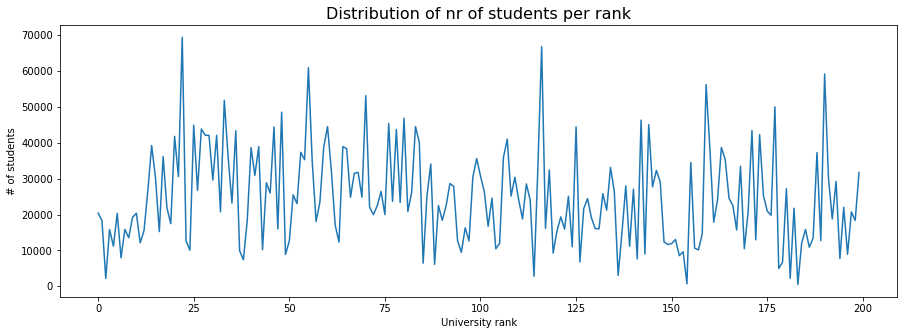

In [92]:
x = range(0, 200)
y = data_thedu.stats_number_students

fig = plt.figure(figsize=(15,5))
plt.plot(x, y)
plt.xlabel('University rank')
plt.ylabel('# of students')
_ = plt.title('Distribution of nr of students per rank', fontsize=16)

The above plot confirms our previous assumption as we can clearly see the high variance in the distribution of

Another interesting thing to check visually using barplot is if there is a high variance between the number of international students between the first 10, middle 10 and the last 5 universities.

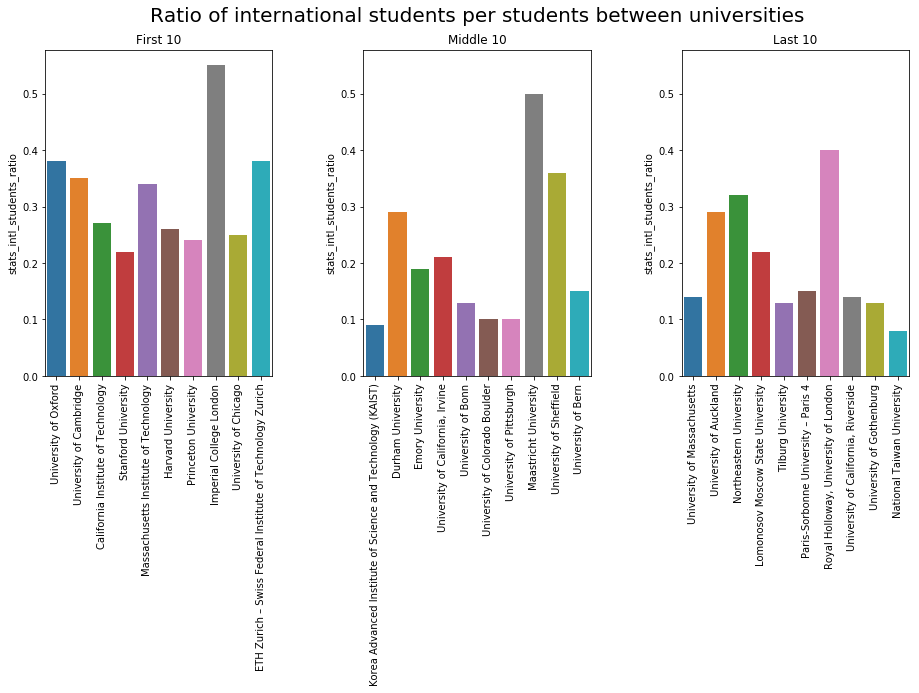

In [73]:
first_10 = data_thedu[:10]
middle_10 = data_thedu[95:105]
last_10 = data_thedu[-10:]

fig = plt.figure(figsize=(15,6))
fig.suptitle('Ratio of international students per students between universities', fontsize=20)

ax1 = plt.subplot(1, 3, 1)
sns.barplot(x='name', y='stats_intl_students_ratio', data=first_10)
plt.xticks(rotation=90)
plt.xlabel('')
ax1.set_title('First 10')


ax2 = plt.subplot(1, 3, 2, sharey=ax1)
sns.barplot(x='name', y='stats_intl_students_ratio', data=middle_10)
plt.xticks(rotation=90)
plt.xlabel('')
ax2.set_title('Middle 10')

ax3 = plt.subplot(1, 3, 3, sharey=ax1)
sns.barplot(x='name', y='stats_intl_students_ratio', data=last_10)
plt.xticks(rotation=90)
plt.xlabel('')
ax3.set_title('Last 10')

plt.subplots_adjust(left=0.1,wspace=0.4)

We can observe there is clearly a drop in consistency in the ratio of international students per students between the first 10 universities and the 10 in the middle, but the ratio is comparable between the 10 universities in the middle and the last 10. Which makes us think that maybe after a certain rank, students do not make a concrete difference between the universities.

As a last point we want to look at the number of universities each of the country has in the top 200 

In order to do this, we will group again the data by country but this time we will count the number of entries for each. Then we will do a barplot for the resulted dataframe.

In [74]:
universities_per_country = thedu_agg[['location','name']].groupby('location').count()
universities_per_country.columns = ['universities']

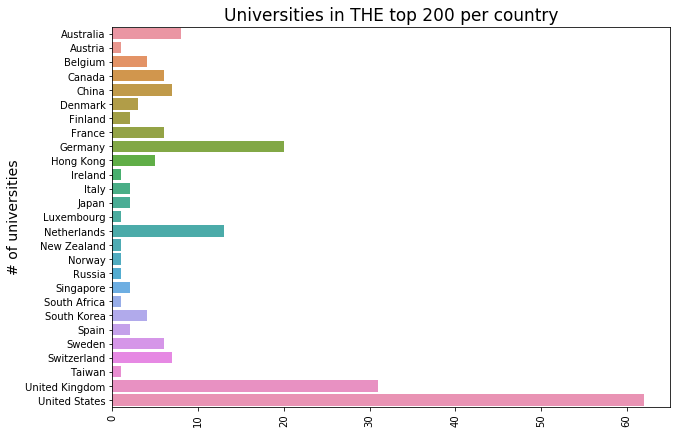

In [75]:
plt.figure(figsize=(10,7))
sns.barplot(y='location', x='universities', data=universities_per_country.reset_index())
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('# of universities', fontsize=14)
_ = plt.title('Universities in THE top 200 per country', fontsize=17)

We can easily observe that there are four countries that make more than half of the universities in top 200: United States, United Kingdome, Germany and Netherlands, while the rest of the countries contribute with less than 10.

## 3. Merging the two DataFrames
<div class="alert alert-block alert-info">
**Task**: Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.
</div>

Solution: for this task we will try to normalize the universities name in both datasets, i.e. try to extract only the useful information from each university name and then try to match only using that information. For that, we first need to understand better our data. As we observed, we have multiple universities names followed by their acronyms in the TU dataset. Let's analyze in a more in-dept manner those cases:

In [93]:
TU_df[TU_df.title.apply(lambda x: True if '(' in x else False)].title

0            Massachusetts Institute of Technology (MIT)
3           California Institute of Technology (Caltech)
6                        UCL (University College London)
10     Nanyang Technological University, Singapore (NTU)
11       Ecole Polytechnique Fédérale de Lausanne (EPFL)
14                National University of Singapore (NUS)
26              University of California, Berkeley (UCB)
32          University of California, Los Angeles (UCLA)
34     London School of Economics and Political Scien...
38            University of California, San Diego (UCSD)
44       The University of New South Wales (UNSW Sydney)
45            The Chinese University of Hong Kong (CUHK)
51                             New York University (NYU)
70     Pohang University of Science And Technology (P...
74                     Universidad de Buenos Aires (UBA)
76                      National Taiwan University (NTU)
107                       Sungkyunkwan University (SKKU)
113                            

It can be seen that, besides one name, all the ones that contain a parantheses keep the acronym of the university appended to the name. It is not the case of UCL, where in fact the full name is in parantheses, while the acronym is outside. We will have to handle this case.

Also, one really important thing to notice is that some universities have their name stated in the native language in one ranking, while in the other one is in English. This is the case, for example, of **Technical University of Berlin**, as named in the THE tanking, which in is named **Technische Universität Berlin (TU Berlin)** in the TU ranking. Therefore, one more thing we should handle should be language differences. The solution for that would be to translate every university name in English language, using an API which makes requests to Google Translate servers. In that manner, all names will be expressed in the same language.

Note: in order to install the Google Translate module for API calls, we use pip install googletrans

Another issue is that some names have some additional not-so-meaningful words in their structure, as *of* or *the*. An example of this is **The university of Hong Kong**, as per TU ranking, and **University of Hong Kong**, as expressed in THE ranking. This problem will be solved by eliminating the unncecessary words and punctuation signs.

Last issue concerned is the words order. We might have universities that appear in both rankings, but with different order of words, or even the different order might be injected by the previous translation. We solve the problem by representing the normalized name as a set of words, so that the order of the words don't matter when similarity is established.

Therefore, the solution for normalizing names is as follows: for **UCL**, transform the name into **University College London**, to keep consistency in the dataset. Then, get rid of the acronym when exists, transform name to lower case and replace punctation marks in name. After that, translate name in English, get rid of the linking words and then split the name into words. Finally, the representation will be consisting of the set of all words resulted from the last operation. The implementation is presented below:

In [94]:
from googletrans import Translator
# googletrans is a library which makes calls to the google translate servers in order to translate words or sentences.

def normalize_university_name(name):
    translator = Translator()
    if name == 'UCL (University College London)':
        name = 'University College London' 
        # UCL is the only university for which the acronym is first and full name in parantheses, solve that problem by hand
    name = name.lower()
    CHARACTERS_REPLACE_BEFORE_TRANSLATE = [' – ', ' - ', '-', ' & ', ', '] # characters which don't contain letters
    CHARACTERS_REPLACE_AFTER_TRANSLATE = [' and ', ' in ', ' of ', ' from '] # english words (used after translation)
    
    name = name.replace('’', "'") # replace weird character
    for character_to_replace in CHARACTERS_REPLACE_BEFORE_TRANSLATE:
        name = name.replace(character_to_replace, ' ') 
    
    if '(' in name:
        name = name.rpartition('(')[0] # consider only the string before the last occurence of (, which is the full name of the university
        
    name = translator.translate(name, dest='en').text # transform the name of the university into English text, so that we can compare words
    
    for character_to_replace in CHARACTERS_REPLACE_AFTER_TRANSLATE:
        name = name.replace(character_to_replace, ' ') 
    
    name = name.lower() # needed again, Google translate might be a "good" hero and transform everything in big letters 
    words = name.strip().split() # split the university name in words
    return set(words) # return the words representing university name as a set, for unordered checking   


After we found a good way of normalizing the names, we must use it for establishing the link between universities using the names in the two dataset. For that, we will consider, for each university in the TU dataset, all of the universities from THE dataset that are from the same country (FIRST thing to check should be country, if not from the same country then clearly not same university) and have the property that all the words in one representation are present in the other representation. For example, we will want that **Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento** is matched by **Scuola Superiore Sant’Anna**, which is possible by using this condition. Furthermore, from all the matching universities, we will select the one that has the most common words with the current university. 

In [95]:
def delete_entry_by_university_name(university_name, universities_normalized):
    for index, pair in enumerate(universities_normalized):
        if pair[1] == university_name:
            del universities_normalized[index]
            return
        
def pair_universities():
    THE_universities_normalized = []
    for university_data in data_thedu[['name', 'location']].itertuples():
        THE_universities_normalized.append((normalize_university_name(university_data.name), university_data.name, university_data.location))
        # keep tuples of the form (normalized_name, name, location)

    paired = []
    unpaired = []

    for university_data in TU_df[['title', 'country']].itertuples():
        normalized_university = normalize_university_name(university_data.title)
        country_university = university_data.country

        best_words_match_number = -1 # initially, we set the biggest number of matches to -1
        best_match_university = None # initially, the best match university is None

        for THE_normalized_university, THE_university, THE_country in THE_universities_normalized:
            if THE_country.lower() != country_university.lower():
                continue # if not from the same country, then it's not a match

            if normalized_university.issubset(THE_normalized_university) or THE_normalized_university.issubset(normalized_university):
                words_intersection = normalized_university.intersection(THE_normalized_university)

                if len(words_intersection) > best_words_match_number:
                    best_words_match_number = len(words_intersection)
                    best_match_university = THE_university

        if best_match_university is not None: # we found match
            paired.append((university_data.title, best_match_university))
            delete_entry_by_university_name(best_match_university, THE_universities_normalized) # delete matched university from the list

        else:
            unpaired.append((university_data.title, university_data.country))

    THE_unpaired = [(pair[1], pair[2]) for pair in THE_universities_normalized]

    return paired, unpaired, THE_unpaired


In [96]:
paired, TU_unpaired, THE_unpaired = pair_universities() # Code for pairing universities

Next, we want to make sure we did not insert some inconsistencies. We will print every pair and will actually inspect it for mistakes. In the lines below, we only print the first 10 lines, but the curious reviewer could watch <a href="#all_pairs"> here (Appendix) </a> all the matched universities:

In [97]:
TU_pair = pd.Series([element[0] for element in paired])
THE_pair = pd.Series([element[1] for element in paired])

paired_dataframe = pd.DataFrame({'TU' : TU_pair, 'THE' : THE_pair})
paired_dataframe.head(10)

,THE,TU
0,Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT)
1,Stanford University,Stanford University
2,Harvard University,Harvard University
3,California Institute of Technology,California Institute of Technology (Caltech)
4,University of Cambridge,University of Cambridge
5,University of Oxford,University of Oxford
6,University College London,UCL (University College London)
7,Imperial College London,Imperial College London
8,University of Chicago,University of Chicago
9,ETH Zurich – Swiss Federal Institute of Techno...,ETH Zurich - Swiss Federal Institute of Techno...


Our analysis lead to discovering two bad pairings: (***Universitat de Barcelona***, ***Autonomous University of Barcelona***) and ***Vrije Universiteit Brussel (VUB)***, ***Université Libre de Bruxelles***). We will have to delete these two pairs from the list. Now, let's inspect the unpaired university names from TU ranking, indexed by country, as below:

In [98]:
TU_unpaired_name = pd.Series([element[0] for element in TU_unpaired])
TU_unpaired_country = pd.Series([element[1] for element in TU_unpaired])

TU_unpaired_dataframe = pd.DataFrame({'name' : TU_unpaired_name, 'country' : TU_unpaired_country})
TU_unpaired_dataframe['source'] = 'TU'

TU_unpaired_dataframe = TU_unpaired_dataframe.set_index(['country', 'source']).sort_index()

TU_unpaired_dataframe.head()

name
country   source                                             
Argentina TU                Universidad de Buenos Aires (UBA)
Australia TU                  University of Technology Sydney
Austria   TU                  Vienna University of Technology
Brazil    TU                        Universidade de São Paulo
          TU      Universidade Estadual de Campinas (Unicamp)

Now for THE dataset, the unpaired universities are:

In [99]:
THE_unpaired_name = pd.Series([element[0] for element in THE_unpaired])
THE_unpaired_country = pd.Series([element[1] for element in THE_unpaired])

THE_unpaired_dataframe = pd.DataFrame({'name' : THE_unpaired_name, 'country' : THE_unpaired_country})
THE_unpaired_dataframe['source'] = 'THE'

THE_unpaired_dataframe = THE_unpaired_dataframe.set_index(['country', 'source']).sort_index()

THE_unpaired_dataframe.head()

name
country source                                                   
France  THE     Paris Sciences et Lettres – PSL Research Unive...
        THE                                  Paris-Sud University
        THE                   Paris-Sorbonne University – Paris 4
Germany THE                                            LMU Munich
        THE                                University of Freiburg

Finally, we will merge the two datasets and index it by country. Afterwards, we can look for the universities in the same country, for pairs between THE and TU. Again, In the lines below, we only print the first 10 lines, but the curious reviewer could watch <a href="#all_unpaired"> here (Appendix) </a> all the unpaired universities:

In [100]:
merged_unpaired_dataframe = pd.concat([TU_unpaired_dataframe, THE_unpaired_dataframe]).sort_index()
merged_unpaired_dataframe.head(10)

name
country   source                                                   
Argentina TU                      Universidad de Buenos Aires (UBA)
Australia TU                        University of Technology Sydney
Austria   TU                        Vienna University of Technology
Brazil    TU                              Universidade de São Paulo
          TU            Universidade Estadual de Campinas (Unicamp)
Canada    TU                                 University of Waterloo
Chile     TU          Pontificia Universidad Católica de Chile (UC)
          TU                                   Universidad de Chile
France    THE     Paris Sciences et Lettres – PSL Research Unive...
          THE                                  Paris-Sud University

We can see that most of the universities are unrelated, but some of them were not detected as matching, even though they are in reality. Several are really hard to detect even by humans, without some extra information that could be found by using Google. A good example for that is ***Albert-Ludwigs-Universitaet Freiburg***, which appears in THE dataset as ***University of Freiburg***, and only a Google search, a local or an expert in universities could detect that this is actually the same university. All of the found matches could be seen below, where we finalize the list of matching universities:

In [101]:
paired.remove(('Universitat de Barcelona' ,'Autonomous University of Barcelona'))
paired.remove(('Vrije Universiteit Brussel (VUB)', 'Université Libre de Bruxelles'))

paired.append(('Ludwig-Maximilians-Universität München', 'LMU Munich'))
paired.append(('Albert-Ludwigs-Universitaet Freiburg', 'University of Freiburg'))
paired.append(('Lomonosov Moscow State University', 'Lomonosov Moscow State University'))
paired.append(('Universitat Autònoma de Barcelona', 'Autonomous University of Barcelona'))
paired.append(('Washington University in St. Louis', 'Washington University in St Louis'))

len(paired)

161

Finally, we merge the two datasets, keeping the information only for the universities that appear in the both datasets. For that, we will keep the name of the university as it appears in TU ranking. The merging result can be seen below:

In [102]:
def transform_cell_to_numeric(cell_value):
    '''Function that transforms a cell value into a numeric value. Note that for ties in the rank column in THE rank, the 
    value starts with ='''
    if cell_value.startswith("="):
        cell_value = cell_value[1:]
    
    return pd.to_numeric(cell_value)

In [103]:
THE_names_to_TU_names = {key:value for value, key in paired} 
# dictionary which maps the universities names from THE ranking to the universities names from TU ranking, for all universities
# that appear in both rankings

THE_df = data_thedu.copy()

THE_df['name'] = THE_df['name'].apply(lambda x: THE_names_to_TU_names[x] if x in THE_names_to_TU_names else x)
# transforms the name of the universities that also appeat in TU ranking in their equivalent from TU
THE_df.rename(columns={'name':'title', 'rank':'rank_display', 'stats_number_students':'Total students', 
                      'stats_intl_students_ratio':'Ratio intl/total students', 
                      'stats_staff_student_ratio':'Ratio faculty/students',
                      'number_international_students_inferred':'International students',
                      'number_faculty_members_inferred':'Total faculty members',
                      'scores_overall' : 'score'}, inplace=True)

THE_df['rank_display'] = THE_df['rank_display'].apply(transform_cell_to_numeric) # transform cell to numeric
THE_df['score'] = THE_df['score'].apply(transform_cell_to_numeric) # transform cell to numeric

TU_df['rank_display'] = TU_df['rank_display'].apply(transform_cell_to_numeric) # transform cell to numeric
TU_df['score'] = TU_df['score'].apply(transform_cell_to_numeric) # transform cell to numeric

merged_df = TU_df.merge(THE_df, on='title', how='inner', suffixes=('_TU', '_THE'))
merged_df = merged_df.reindex_axis(sorted(merged_df.columns), axis=1)
merged_df = merged_df.drop('location', axis=1) # drop redundant column

In [104]:
merged_df.head()

,International faculty members,International students_THE,International students_TU,Ratio faculty/students_THE,Ratio faculty/students_TU,Ratio intl/total students_THE,Ratio intl/total students_TU,Total faculty members_THE,Total faculty members_TU,Total students_THE,Total students_TU,country,rank_display_THE,rank_display_TU,region,score_THE,score_TU,title
0,1679.0,3800.18,3717.0,0.114943,0.269450,0.34,0.335863,1284.712644,2982.0,11177,11067.0,United States,5,1,North America,92.5,100.0,Massachusetts Institute of Technology (MIT)
1,2042.0,3485.90,3611.0,0.133333,0.269870,0.22,0.227422,2112.666667,4285.0,15845,15878.0,United States,3,2,North America,93.0,98.7,Stanford University
2,1311.0,5284.76,5266.0,0.112360,0.193945,0.26,0.234785,2283.820225,4350.0,20326,22429.0,United States,6,3,North America,91.8,98.4,Harvard University
3,350.0,596.43,647.0,0.153846,0.422616,0.27,0.286918,339.846154,953.0,2209,2255.0,United States,3,4,North America,93.0,97.7,California Institute of Technology (Caltech)
4,2278.0,6436.15,6699.0,0.091743,0.292488,0.35,0.356899,1687.064220,5490.0,18389,18770.0,United Kingdom,2,5,Europe,93.2,95.6,University of Cambridge


## 4. Data Insights
<div class="alert alert-block alert-info">
**Task**: Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?
</div>

First, we can look at the data in the merged DataFrame from *Task 3*, and to make comparisons between the data in the two datasets. We can first see that the number of *International students* is very similar in the two datasets, having very small variations, usually under 1% of the actual value. Also, it is the same case regarding the *Ratio intl/total students* and *Total students* columns. It is somewhat expected to have similar data, because it should reflect the same reality.

In [105]:
merged_df[['title', 'International students_TU', 'International students_THE', 
           'Ratio intl/total students_TU', 'Ratio intl/total students_THE',
          'Total students_TU', 'Total students_THE']].head()

,title,International students_TU,International students_THE,Ratio intl/total students_TU,Ratio intl/total students_THE,Total students_TU,Total students_THE
0,Massachusetts Institute of Technology (MIT),3717.0,3800.18,0.335863,0.34,11067.0,11177
1,Stanford University,3611.0,3485.90,0.227422,0.22,15878.0,15845
2,Harvard University,5266.0,5284.76,0.234785,0.26,22429.0,20326
3,California Institute of Technology (Caltech),647.0,596.43,0.286918,0.27,2255.0,2209
4,University of Cambridge,6699.0,6436.15,0.356899,0.35,18770.0,18389


However, shocking enough, we can see that the data in the column *Ratio faculty/students* differ significantly between TU and THE rankings, i.e. by a factor or 2 or even 3. Then, this is followed by a chain reaction, knowing that we inferred the value of *Total faculty members* in THE ranking based on the *Ratio faculty/students* and *Total students* values. This is really unexpected, and the most probable explanation would be that the two sources use the same name for expressing different notions, i.e. THE might include only staff that actually is involved in the teaching process, while TU includes in the *faculty* class also the researchers that work in a university lab, but are not involved in the teaching process. 

In [106]:
merged_df[['title', 'Ratio faculty/students_TU', 'Ratio faculty/students_THE', 
           'Total faculty members_TU', 'Total faculty members_THE']].head()

,title,Ratio faculty/students_TU,Ratio faculty/students_THE,Total faculty members_TU,Total faculty members_THE
0,Massachusetts Institute of Technology (MIT),0.269450,0.114943,2982.0,1284.712644
1,Stanford University,0.269870,0.133333,4285.0,2112.666667
2,Harvard University,0.193945,0.112360,4350.0,2283.820225
3,California Institute of Technology (Caltech),0.422616,0.153846,953.0,339.846154
4,University of Cambridge,0.292488,0.091743,5490.0,1687.064220


If we try to go out in the jungle and find some explanations for the discrepancies, we will find them in the end. Therefore, in the methodology presented by the TU website in the following <a href= "https://www.topuniversities.com/qs-world-university-rankings/methodology">link</a>, the *ratio faculty/students* is described as *it assesses the extent to which institutions are able to provide students with meaningful access to lecturers and tutors*, therefore it is the ratio between the **teaching** staff and **all** the students. In the same time, for THE ranking, we can discover in <a href="https://en.wikipedia.org/wiki/Times_Higher_Education_World_University_Rankings"> this link </a> that the ratio given is in fact *Undergrad. admitted per academic*, therefore not all the students are included in the function that computes the ratio.
***

Also, really interesting is the difference in positions/ranks for universities, in the two datasets. The first 10 universities are similar, with minor changes in some positions, proving that those 10 universities have their rightful place in the top of the ranking. However, after the first 10 universities, things are starting to become chaotic, with very big differences in ranking, sometimes with even 76 places, as in *Fudan University* case.

In [107]:
merged_df[['title', 'score_TU', 'score_THE', 
           'rank_display_TU', 'rank_display_THE']].head(15)

,title,score_TU,score_THE,rank_display_TU,rank_display_THE
0,Massachusetts Institute of Technology (MIT),100.0,92.5,1,5
1,Stanford University,98.7,93.0,2,3
2,Harvard University,98.4,91.8,3,6
3,California Institute of Technology (Caltech),97.7,93.0,4,3
4,University of Cambridge,95.6,93.2,5,2
5,University of Oxford,95.3,94.3,6,1
6,UCL (University College London),94.6,85.3,7,16
7,Imperial College London,93.7,89.2,8,8
8,University of Chicago,93.5,88.6,9,9
9,ETH Zurich - Swiss Federal Institute of Techno...,93.3,87.7,10,10


An interesting value that we are be interested in looking at is the absolute value of difference of positions in the two rankings, per university. We present the **biggest** differences in ranks between the two datasets below:

In [108]:
score_difference = pd.DataFrame(merged_df['title'])
score_difference['abs_rank_diff'] = (merged_df['rank_display_THE'] - merged_df['rank_display_TU']).apply(abs)

score_difference.sort_values(by='abs_rank_diff', ascending=False).head()

,title,abs_rank_diff
59,Shanghai Jiao Tong University,126
71,National Taiwan University (NTU),122
76,The University of Auckland,110
140,University of Minnesota,107
88,Lomonosov Moscow State University,99


Also, the mean and the standard deviation of the absolute value of the differences in rank for the two datasets are very large, as computed below:

In [109]:
score_difference['abs_rank_diff'].mean(), score_difference['abs_rank_diff'].std()

(32.65625, 27.886798769265077)

Therefore, the two sources have a really different formula for computing the ranking, taking into consideration diverse and different factors for each university measure of "success".
***
Furthermore, if we only look inside one single dataset, namely TU, we might be interested in the correlation between the international faculty members and the international students. We present it below for the first 10 universities:

In [110]:
merged_df[['title', 'International faculty members', 'International students_TU']].head(10)

,title,International faculty members,International students_TU
0,Massachusetts Institute of Technology (MIT),1679.0,3717.0
1,Stanford University,2042.0,3611.0
2,Harvard University,1311.0,5266.0
3,California Institute of Technology (Caltech),350.0,647.0
4,University of Cambridge,2278.0,6699.0
5,University of Oxford,2964.0,7353.0
6,UCL (University College London),2554.0,14854.0
7,Imperial College London,2071.0,8746.0
8,University of Chicago,635.0,3379.0
9,ETH Zurich - Swiss Federal Institute of Techno...,1886.0,7563.0


It is interesting to observe that the number of international professors usually grows with the number of international students. This might be a consequence of the fact that a fraction of the international students also have a teaching position after graduation, becoming now part of the staff.
***

All of these results can also be observed in the DataFrame representing the correlations matrix between any two (numeric) attributes, as below:

In [111]:
merged_df.corr()

,International faculty members,International students_THE,International students_TU,Ratio faculty/students_THE,Ratio faculty/students_TU,Ratio intl/total students_THE,Ratio intl/total students_TU,Total faculty members_THE,Total faculty members_TU,Total students_THE,Total students_TU,rank_display_THE,rank_display_TU,score_THE,score_TU
International faculty members,1.000000,0.534817,0.561750,0.018897,0.317975,0.327450,0.382804,0.294748,0.618408,0.277060,0.274398,-0.358187,-0.514995,0.418799,0.543209
International students_THE,0.534817,1.000000,0.927685,-0.323399,-0.230435,0.511512,0.531098,0.211570,0.413630,0.560481,0.591198,-0.282188,-0.283179,0.244028,0.265712
International students_TU,0.561750,0.927685,1.000000,-0.316752,-0.236323,0.413498,0.522243,0.219780,0.442800,0.585655,0.641880,-0.265165,-0.264974,0.222876,0.244160
Ratio faculty/students_THE,0.018897,-0.323399,-0.316752,1.000000,0.695837,-0.028020,-0.066805,0.467017,0.173607,-0.359388,-0.351712,-0.114822,-0.219573,0.233045,0.264060
Ratio faculty/students_TU,0.317975,-0.230435,-0.236323,0.695837,1.000000,0.134418,0.112577,0.174135,0.330709,-0.412181,-0.419327,-0.303571,-0.403073,0.456057,0.483117
Ratio intl/total students_THE,0.327450,0.511512,0.413498,-0.028020,0.134418,1.000000,0.954554,-0.258483,-0.118863,-0.302490,-0.267426,-0.198244,-0.307103,0.250620,0.337826
Ratio intl/total students_TU,0.382804,0.531098,0.522243,-0.066805,0.112577,0.954554,1.000000,-0.239329,-0.074744,-0.233213,-0.197296,-0.221026,-0.318736,0.258292,0.345452
Total faculty members_THE,0.294748,0.211570,0.219780,0.467017,0.174135,-0.258483,-0.239329,1.000000,0.750252,0.550736,0.539571,-0.226460,-0.260095,0.246234,0.239774
Total faculty members_TU,0.618408,0.413630,0.442800,0.173607,0.330709,-0.118863,-0.074744,0.750252,1.000000,0.610479,0.607393,-0.374973,-0.371494,0.397187,0.376592
Total students_THE,0.277060,0.560481,0.585655,-0.359388,-0.412181,-0.302490,-0.233213,0.550736,0.610479,1.000000,0.979771,-0.151882,-0.026782,0.064778,-0.021100


All the considerations before can also be observed in this condensed table, but we can also see that the *score* value for a dataset has a really high correlation with the *rank_display* value in that dataset. That correlation is inverse, obviously, because a high score will result in a high position, which is represented by a small number. Also, the scores between the two datasets are somewhat correlated, with a value of 0.81, which could seem unexpected at the first sight, if we think only about the the fact that, in average, the same university has really big difference in positions between the two datasets.

Therefore, the analysis of the dataset can be concluded with the fact that most of the columns in one ranking dataset are correlated with their pair in the other ranking dataset, except the ones regarding the number of professors, but most important, that the positions of the same university differ very much between the two dataset, excepting the first 10 universities, which can be found in both datasets.

## 5. Best university

<div class="alert alert-block alert-info">
**Task**: Can you find the best university taking in consideration both rankings? Explain your approach.
</div>

For finding the best university, we must keep in mind the observation that we made at the previous task, i.e. the top 10 universities are approximatively the same in both datasets, with minor changes in positions. Therefore, one might conclude that it is understandable that the best university is between the top 10 in both rankings. Let's see those universities more closely:

In [112]:
merged_df.head(10)

,International faculty members,International students_THE,International students_TU,Ratio faculty/students_THE,Ratio faculty/students_TU,Ratio intl/total students_THE,Ratio intl/total students_TU,Total faculty members_THE,Total faculty members_TU,Total students_THE,Total students_TU,country,rank_display_THE,rank_display_TU,region,score_THE,score_TU,title
0,1679.0,3800.18,3717.0,0.114943,0.269450,0.34,0.335863,1284.712644,2982.0,11177,11067.0,United States,5,1,North America,92.5,100.0,Massachusetts Institute of Technology (MIT)
1,2042.0,3485.90,3611.0,0.133333,0.269870,0.22,0.227422,2112.666667,4285.0,15845,15878.0,United States,3,2,North America,93.0,98.7,Stanford University
2,1311.0,5284.76,5266.0,0.112360,0.193945,0.26,0.234785,2283.820225,4350.0,20326,22429.0,United States,6,3,North America,91.8,98.4,Harvard University
3,350.0,596.43,647.0,0.153846,0.422616,0.27,0.286918,339.846154,953.0,2209,2255.0,United States,3,4,North America,93.0,97.7,California Institute of Technology (Caltech)
4,2278.0,6436.15,6699.0,0.091743,0.292488,0.35,0.356899,1687.064220,5490.0,18389,18770.0,United Kingdom,2,5,Europe,93.2,95.6,University of Cambridge
5,2964.0,7755.42,7353.0,0.089286,0.342292,0.38,0.372870,1822.232143,6750.0,20409,19720.0,United Kingdom,1,6,Europe,94.3,95.3,University of Oxford
6,2554.0,14848.96,14854.0,0.095238,0.204151,0.49,0.477928,2886.095238,6345.0,30304,31080.0,United Kingdom,16,7,Europe,85.3,94.6,UCL (University College London)
7,2071.0,8721.35,8746.0,0.087719,0.244251,0.55,0.543567,1390.964912,3930.0,15857,16090.0,United Kingdom,8,8,Europe,89.2,93.7,Imperial College London
8,635.0,3381.25,3379.0,0.161290,0.180645,0.25,0.249244,2181.451613,2449.0,13525,13557.0,United States,9,9,North America,88.6,93.5,University of Chicago
9,1886.0,7308.54,7563.0,0.068493,0.125006,0.38,0.381681,1317.328767,2477.0,19233,19815.0,Switzerland,10,10,Europe,87.7,93.3,ETH Zurich - Swiss Federal Institute of Techno...


We might observe that, in fact, the first 6 positions in TU ranking are occupied by the same universities in THE ranking, up to a permutation of rankings. Therefore, we can restrict our search only to the first 6 universities:

In [113]:
top_6 = merged_df.head(6)[['title', 'region', 'rank_display_TU', 'rank_display_THE', 'score_TU', 'score_THE']]
top_6

,title,region,rank_display_TU,rank_display_THE,score_TU,score_THE
0,Massachusetts Institute of Technology (MIT),North America,1,5,100.0,92.5
1,Stanford University,North America,2,3,98.7,93.0
2,Harvard University,North America,3,6,98.4,91.8
3,California Institute of Technology (Caltech),North America,4,3,97.7,93.0
4,University of Cambridge,Europe,5,2,95.6,93.2
5,University of Oxford,Europe,6,1,95.3,94.3


We might consider the score generated by both websites for each university. Each ranking source has a different methodology for computing the score, taking into consideration very diverse factors, as it can be seen exactly in the links from the previous tasks. What is for sure is that both websites invested a lot of effort in finding a good formula, thus we can actually think to give a final score to each university, based on the scores from the two sources.

Though, we do not know what weights to use for both scores, and this should be a really hard task and subjectivity interfers in the process. Though, if we consider that both ranking websites have an equal share of truth, we can simply just consider our score as the sum of the two scores. It is way better to consider the score than the rank, because the rank can only the positive integer values, while the score can take rational values, thus it is more fragmented and close to reality. 

We observe that the highest score in TU ranking is 100, while highest score in THE ranking is 94.3, which is actually smaller than the score in TU for any university in top 6. Therefore, we need to transform the scores, and for that we will normalize them, making the mean 50 and the standard deviation 1 for both datasets. In this case, we have:

In [114]:
top_6['score_TU_standardized'] = (top_6['score_TU'] - top_6['score_TU'].mean()) / top_6['score_TU'].std() + 50
# Should be careful with the normalization formula, first add to mean 0, do the division then add the desired mean, otherwise
# we insert errors.
top_6['score_THE_standardized'] = (top_6['score_THE'] - top_6['score_THE'].mean()) / top_6['score_THE'].std() + 50

top_6['combined_score'] = top_6['score_TU_standardized'] + top_6['score_THE_standardized'] 
top_6.sort_values(by='combined_score', ascending=False)

,title,region,rank_display_TU,rank_display_THE,score_TU,score_THE,score_TU_standardized,score_THE_standardized,combined_score
0,Massachusetts Institute of Technology (MIT),North America,1,5,100.0,92.5,51.296043,49.435190,100.731233
1,Stanford University,North America,2,3,98.7,93.0,50.589110,50.040344,100.629454
5,University of Oxford,Europe,6,1,95.3,94.3,48.740210,51.613743,100.353953
3,California Institute of Technology (Caltech),North America,4,3,97.7,93.0,50.045316,50.040344,100.085660
4,University of Cambridge,Europe,5,2,95.6,93.2,48.903348,50.282405,99.185753
2,Harvard University,North America,3,6,98.4,91.8,50.425972,48.587975,99.013947


Therefore, the best university is MIT, with a combined score of 100.73, followed closely by Stanford university, with 100.62. We can see that maybe looking only at the rankings, it would be intuitive for Stanford university to be considered the best one, being in the top 3 in both rankings, but giving equal weights to both rankings results in MIT being the winner.

We must stress out again that we consider both rankings equally good, because both have extensive expertise in the domain, and cannot have different weights without being subjective. 


## Appendix.

<a id="all_pairs"></a>In the next table, we have all pairs that resulted from the matching code: 

In [115]:
paired_dataframe

,THE,TU
0,Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT)
1,Stanford University,Stanford University
2,Harvard University,Harvard University
3,California Institute of Technology,California Institute of Technology (Caltech)
4,University of Cambridge,University of Cambridge
5,University of Oxford,University of Oxford
6,University College London,UCL (University College London)
7,Imperial College London,Imperial College London
8,University of Chicago,University of Chicago
9,ETH Zurich – Swiss Federal Institute of Techno...,ETH Zurich - Swiss Federal Institute of Techno...


<a id="all_unpaired"></a>In the next table, we have all the universities that were not paired by the matching code: 

In [116]:
merged_unpaired_dataframe

name
country        source                                                   
Argentina      TU                      Universidad de Buenos Aires (UBA)
Australia      TU                        University of Technology Sydney
Austria        TU                        Vienna University of Technology
Brazil         TU                              Universidade de São Paulo
               TU            Universidade Estadual de Campinas (Unicamp)
Canada         TU                                 University of Waterloo
Chile          TU          Pontificia Universidad Católica de Chile (UC)
               TU                                   Universidad de Chile
France         THE     Paris Sciences et Lettres – PSL Research Unive...
               THE                                  Paris-Sud University
               THE                   Paris-Sorbonne University – Paris 4
               TU                        Ecole normale supérieure, Paris
               TU                                        CentraleSupélec
Germany        THE                                            LMU Munich
               THE                                University of Freiburg
               THE                                    University of Bonn
               THE                                University of Mannheim
               THE                  Charité - Universitätsmedizin Berlin
               THE                                 University of Cologne
               THE                                            TU Dresden
               THE                                        Ulm University
               THE                      University of Erlangen-Nuremberg
               THE                                University of Würzburg
               THE                                 University of Münster
               TU                 Ludwig-Maximilians-Universität München
               TU                   Albert-Ludwigs-Universitaet Freiburg
India          TU            Indian Institute of Technology Delhi (IITD)
               TU           Indian Institute of Technology Bombay (IITB)
               TU           Indian Institute of Science (IISc) Bangalore
Ireland        TU                              University College Dublin
Israel         TU                     The Hebrew University of Jerusalem
Italy          TU                                  Politecnico di Milano
               TU           Alma Mater Studiorum - University of Bologna
Japan          TU                          Tokyo Institute of Technology
               TU                                       Osaka University
               TU                                      Tohoku University
               TU                                      Nagoya University
               TU                                    Hokkaido University
               TU                                      Kyushu University
               TU                               Keio University CEMS MIM
Luxembourg     THE                              University of Luxembourg
Malaysia       TU                                 Universiti Malaya (UM)
Mexico         TU        Universidad Nacional Autónoma de México  (UNAM)
               TU      Instituto Tecnológico y de Estudios Superiores...
Netherlands    THE                           Radboud University Nijmegen
               THE                          Vrije Universiteit Amsterdam
               THE                                    Tilburg University
New Zealand    TU                                    University of Otago
Norway         TU                                   University of Bergen
Saudi Arabia   TU           King Fahd University of Petroleum & Minerals
South Korea    TU                                       Korea University
               TU                                      Yonsei University
               TU                                     Hanyang University
Spain          THE                               Pomp